## DenseNet201

- Searching through similar studies, some have used the DenseNet 201 pre-trained model in keras.

In [2]:
# Standard Imports
import numpy as np

# Importing all relevant packages for modeling in keras
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import packages for showing the performance metrics
from sklearn.metrics import confusion_matrix

# Importing local functions
import sys
sys.path.append('../src')
import eval_plots

# Setting the random seed for reproducability
np.random.seed(123)

### Initializing the paths to the data directories.

In [5]:
# Defining paths to the split data
train_folder = '../data/split/train/'

test_folder = '../data/split/test/'

val_folder = '../data/split/validation/'

### Setting up the Image Data Flow

In [6]:
# set up batch generator for train set with 1000 as the batch size
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(100, 100), 
        batch_size = 256,
        class_mode='binary',
        shuffle=False)

# set up batch generator for test set with 1000 as the batch size
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = 32,
        class_mode='binary',
        shuffle=False) 

# set up batch generator for validation set with 1000 as the batch size
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100), 
        batch_size = 32,
        class_mode='binary',
        shuffle=False)


Found 48684 images belonging to 2 classes.
Found 16229 images belonging to 2 classes.
Found 16228 images belonging to 2 classes.


In [7]:
# Creating admin tools for the models like automatic saving checkpoints, early stopping routines, etc.
checkpoint = ModelCheckpoint("denseNet201.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=4,
                      verbose=1,
                      mode='auto')

In [8]:
from tensorflow.keras.applications import DenseNet201

def dense_net_201(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='softmax'))
    
    opt = Adam(lr=lr)# beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    print(model.summary())
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(100,100,3)
)

74842112/74836368 [==============================] - 11s 0us/step


In [10]:
# set the model as the first simple model
model = dense_net_201(resnet)

# Fit the model to the train data
history = model.fit(train_generator,
                    epochs = 20,
                    steps_per_epoch=10,
                    validation_data=val_generator,
                    callbacks=[checkpoint],
                    )#

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1921      
Total params: 18,331,585
Trainable params: 18,098,689
Non-trainable params: 232,896
_________________________________________________________________
None
Epoch 1/20
 2/10 [=====>........................] - ETA: 15:07 - loss: 7.6246 - acc: 0.5000 

KeyboardInterrupt: 

## Evaluation

In [153]:
# Test results of the Model on test data
loss_test,accuracy_test = model2.evaluate(test_generator)
print('Model has an accuracy of {} with a loss of {} on the test subset.'.format(accuracy_test,loss_test))

1735/1735 [==============================] - 75s 40ms/step - loss: 0.8081 - acc: 0.5284
Model has an accuracy of 0.5259260535240173 with a loss of 0.8078410029411316 on the test subset.


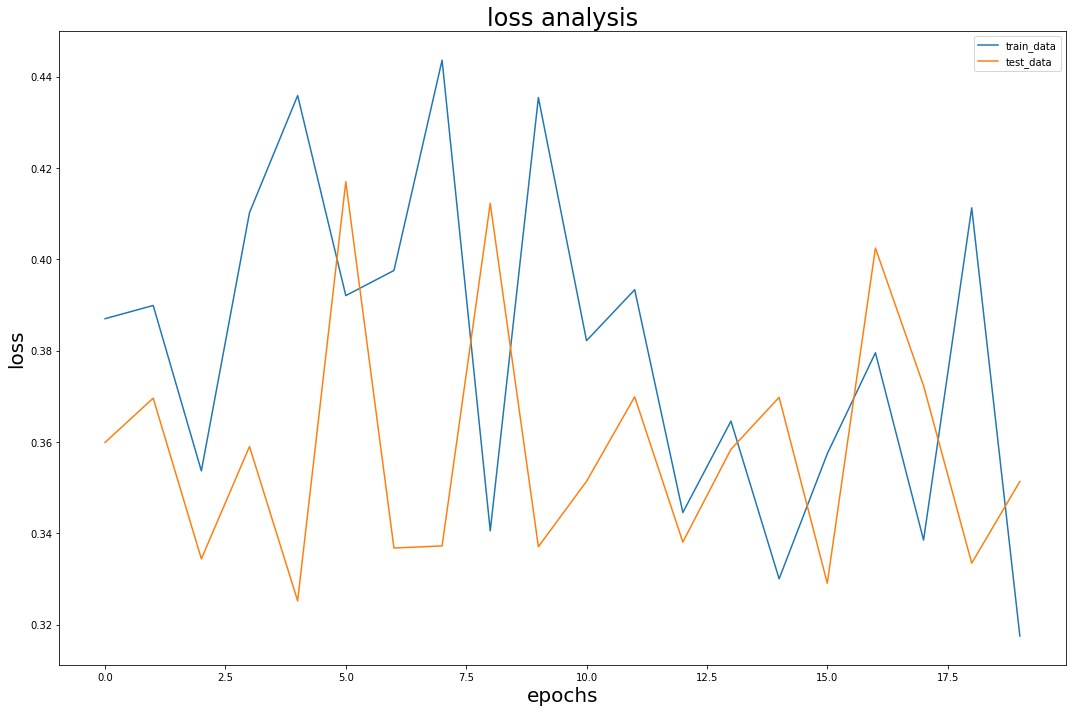

In [154]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epochs', size = 20)
ax.set_ylabel('loss', size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('loss analysis',size = 24)
plt.tight_layout()
# fig.savefig('effNetB0_loss.png')

plt.show()

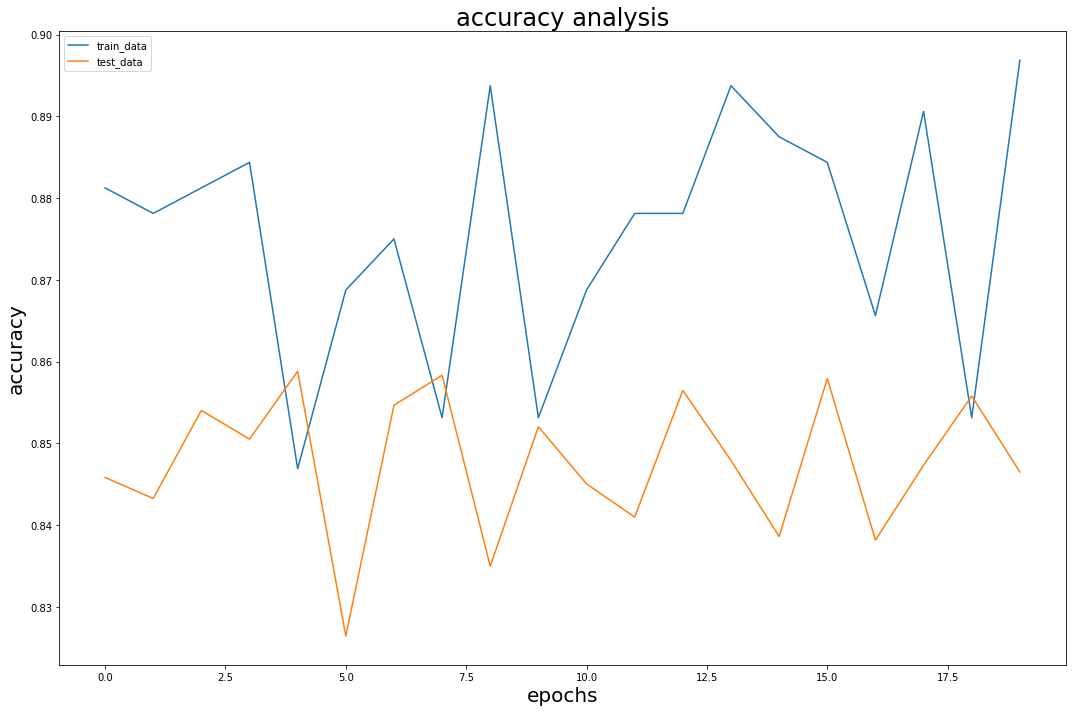

In [155]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_xlabel('epochs',size = 20)
ax.set_ylabel('accuracy',size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('accuracy analysis',size = 24)
plt.tight_layout()
# fig.savefig('effNetB0_acc.png')
plt.show()

In [ ]:
# Plotting the Reciever Operating Curve
models_dict = {'second':[model2,(100,100)]}
test_data_path = '../data/split/test'
eval_plots.plot_rocs(models_dict,test_data_path).show()